In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 드라이브 내 위치로 이동
%cd /content/drive/MyDrive
!unzip FedAvg-Pytorch-main.zip
%cd FedAvg-Pytorch-main

/content/drive/MyDrive
Archive:  FedAvg-Pytorch-main.zip
fb62f4b8b99f9f3e7ad826d5fd7184fa26b5f82c
replace FedAvg-Pytorch-main/Fed_Avg.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Fed_Avg.ipynb  
replace FedAvg-Pytorch-main/Plots/IID.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Plots/IID.png  
replace FedAvg-Pytorch-main/Plots/Non-IID.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Plots/Non-IID.png  
replace FedAvg-Pytorch-main/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/README.md  
replace FedAvg-Pytorch-main/data.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/data.py  
replace FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy  
replace FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m50.npy? [y]es, [n]o, [A]ll,

In [7]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [8]:
# setting random seeds
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

In [9]:
# hyperparams
bsz = 10

In [10]:
# setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are currently using this device:", device)

We are currently using this device: cuda


60000


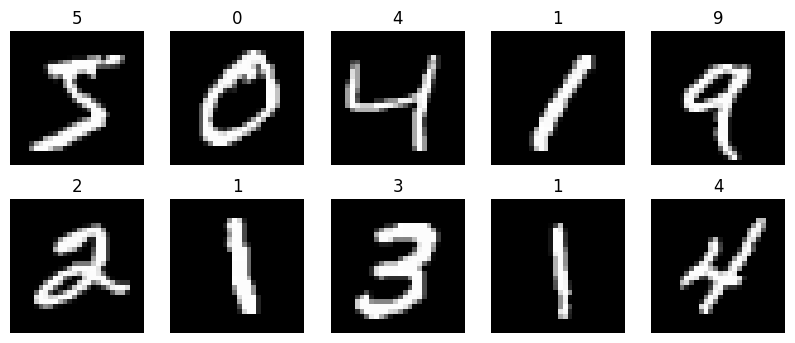

In [11]:
train_data, test_data = fetch_dataset()
print(len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [12]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)


iid:  tensor([54., 70., 55., 48., 60., 52., 64., 69., 60., 68.])


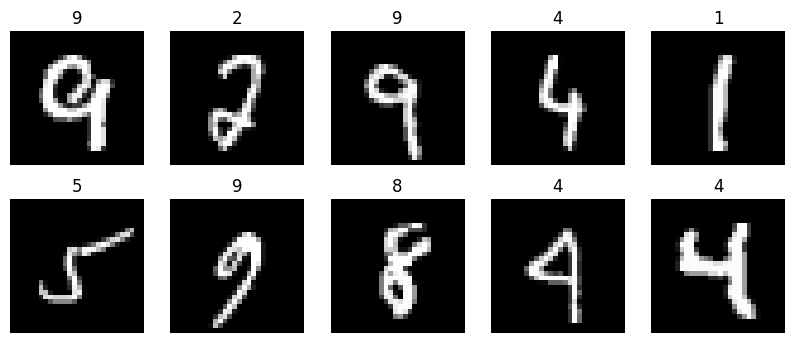

In [13]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([  0.,   0., 600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])


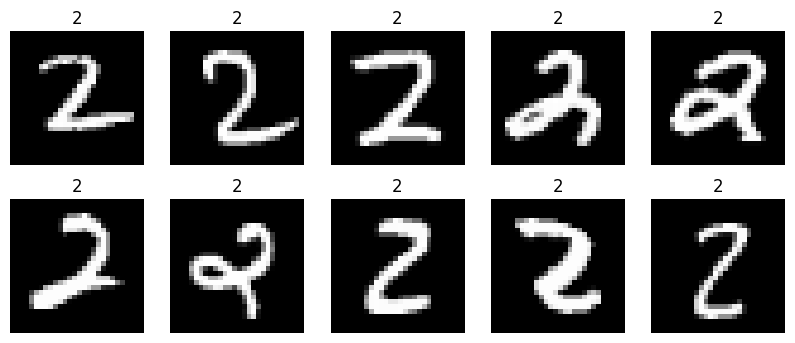

In [14]:
# non-iid
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[10]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

In [15]:
def num_params(model):
    """ """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [16]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # [B x 784]
        x = F.relu(self.fc1(x)) # [B x 200]
        x = F.relu(self.fc2(x)) # [B x 200]
        x = self.out(x) # [B x 10]
        return x

print(MLP())
print(num_params(MLP()))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
199210


In [17]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
582026


In [18]:
## Training

In [19]:
criterion = nn.CrossEntropyLoss()
def validate(model):
    model = model.to(cuda)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [20]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(cuda)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(cpu)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)

        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)


In [21]:
 ## MLP experiments


In [22]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  199210


In [23]:
# MLP - iid - m=10 (number of clients per round) experiment
cpu='cpu'
cuda='cuda'
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=10,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_mlp_iid_m10')
print(acc_mlp_iid_m10)
np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)


starting round 0
clients:  [19 14 43 37 66  3 79 41 38 68]
round 0, starting client 1/10, id: 19
round 0, starting client 2/10, id: 14
round 0, starting client 3/10, id: 43
round 0, starting client 4/10, id: 37
round 0, starting client 5/10, id: 66
round 0, starting client 6/10, id: 3
round 0, starting client 7/10, id: 79
round 0, starting client 8/10, id: 41
round 0, starting client 9/10, id: 38
round 0, starting client 10/10, id: 68
round 0, validation acc: 0.8084
starting round 1
clients:  [34 35 46 36 63 78 82 60 56 61]
round 1, starting client 1/10, id: 34
round 1, starting client 2/10, id: 35
round 1, starting client 3/10, id: 46
round 1, starting client 4/10, id: 36
round 1, starting client 5/10, id: 63
round 1, starting client 6/10, id: 78
round 1, starting client 7/10, id: 82
round 1, starting client 8/10, id: 60
round 1, starting client 9/10, id: 56
round 1, starting client 10/10, id: 61
round 1, validation acc: 0.8726
starting round 2
clients:  [80 47 90 41 26 98 54 66  2 24

In [24]:
# MLP - iid - m=50 (number of clients per round) experiment
mlp_iid_m50 = copy.deepcopy(mlp)
acc_mlp_iid_m50 = fed_avg_experiment(mlp_iid_m50, num_clients_per_round=50,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m50')
print(acc_mlp_iid_m50)
np.save('./acc_mlp_iid_m50.npy', acc_mlp_iid_m50)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
round 9, starting client 12/50, id: 4
round 9, starting client 13/50, id: 50
round 9, starting client 14/50, id: 7
round 9, starting client 15/50, id: 8
round 9, starting client 16/50, id: 81
round 9, starting client 17/50, id: 53
round 9, starting client 18/50, id: 88
round 9, starting client 19/50, id: 33
round 9, starting client 20/50, id: 3
round 9, starting client 21/50, id: 39
round 9, starting client 22/50, id: 72
round 9, starting client 23/50, id: 62
round 9, starting client 24/50, id: 26
round 9, starting client 25/50, id: 80
round 9, starting client 26/50, id: 61
round 9, starting client 27/50, id: 34
round 9, starting client 28/50, id: 5
round 9, starting client 29/50, id: 42
round 9, starting client 30/50, id: 22
round 9, starting client 31/50, id: 29
round 9, starting client 32/50, id: 90
round 9, starting client 33/50, id: 71
round 9, starting client 34/50, id: 93
round 9, starting client 35/50, id: 24
round 9, starting client 36/50, i

In [25]:
# MLP - non-iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=10,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename = './acc_mlp_noniid_m10')
print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)


starting round 0
clients:  [38 77 40 96 71 83 23 20  2  3]
round 0, starting client 1/10, id: 38
round 0, starting client 2/10, id: 77
round 0, starting client 3/10, id: 40
round 0, starting client 4/10, id: 96
round 0, starting client 5/10, id: 71
round 0, starting client 6/10, id: 83
round 0, starting client 7/10, id: 23
round 0, starting client 8/10, id: 20
round 0, starting client 9/10, id: 2
round 0, starting client 10/10, id: 3
round 0, validation acc: 0.2022
starting round 1
clients:  [20 99 80 76 98 31 83  7  0 30]
round 1, starting client 1/10, id: 20
round 1, starting client 2/10, id: 99
round 1, starting client 3/10, id: 80
round 1, starting client 4/10, id: 76
round 1, starting client 5/10, id: 98
round 1, starting client 6/10, id: 31
round 1, starting client 7/10, id: 83
round 1, starting client 8/10, id: 7
round 1, starting client 9/10, id: 0
round 1, starting client 10/10, id: 30
round 1, validation acc: 0.5268
starting round 2
clients:  [69  7 26 11 37 19 10 51 14 33]
r

In [26]:
# MLP - noniid - m=50 experiment
mlp_noniid_m50 = copy.deepcopy(mlp)
acc_mlp_noniid_m50 = fed_avg_experiment(mlp_noniid_m50, num_clients_per_round=50,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m50')
print(acc_mlp_noniid_m50)
np.save('./acc_mlp_noniid_m50.npy', acc_mlp_noniid_m50)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
round 209, starting client 32/50, id: 0
round 209, starting client 33/50, id: 71
round 209, starting client 34/50, id: 73
round 209, starting client 35/50, id: 21
round 209, starting client 36/50, id: 91
round 209, starting client 37/50, id: 53
round 209, starting client 38/50, id: 68
round 209, starting client 39/50, id: 59
round 209, starting client 40/50, id: 86
round 209, starting client 41/50, id: 3
round 209, starting client 42/50, id: 24
round 209, starting client 43/50, id: 69
round 209, starting client 44/50, id: 82
round 209, starting client 45/50, id: 11
round 209, starting client 46/50, id: 32
round 209, starting client 47/50, id: 23
round 209, starting client 48/50, id: 13
round 209, starting client 49/50, id: 48
round 209, starting client 50/50, id: 4
round 209, validation acc: 0.9731
starting round 210
clients:  [70 92 85 99 32 42 96 52 11  8 93 55 12 78 91 84 36 41 23 81 22  2 94 56
 46 65  1 50 20 97  5 71 13 47 25 38 64 14 63 89 48 

In [27]:
## CNN Experiments


In [28]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))
cpu='cpu'
cuda='cuda'


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  582026


In [29]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m10')



starting round 0
clients:  [55 30 72 47 73 99 29 76 79 81]
round 0, starting client 1/10, id: 55
round 0, starting client 2/10, id: 30
round 0, starting client 3/10, id: 72
round 0, starting client 4/10, id: 47
round 0, starting client 5/10, id: 73
round 0, starting client 6/10, id: 99
round 0, starting client 7/10, id: 29
round 0, starting client 8/10, id: 76
round 0, starting client 9/10, id: 79
round 0, starting client 10/10, id: 81
round 0, validation acc: 0.9085
starting round 1
clients:  [70 11 81 69 17 28 98 43 27 74]
round 1, starting client 1/10, id: 70
round 1, starting client 2/10, id: 11
round 1, starting client 3/10, id: 81
round 1, starting client 4/10, id: 69
round 1, starting client 5/10, id: 17
round 1, starting client 6/10, id: 28
round 1, starting client 7/10, id: 98
round 1, starting client 8/10, id: 43
round 1, starting client 9/10, id: 27
round 1, starting client 10/10, id: 74
round 1, validation acc: 0.9333
starting round 2
clients:  [71 73 39 59 76 19 24 97  8 6

In [30]:
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

[0.9085 0.9333 0.9471 0.9549 0.9621 0.9673 0.9691 0.9722 0.9731 0.9748
 0.9754 0.9772 0.9768 0.9776 0.9782 0.9794 0.9794 0.9807 0.9805 0.9814
 0.982  0.9826 0.9823 0.9829 0.9831 0.9828 0.983  0.9837 0.984  0.9842
 0.9853 0.9845 0.9847 0.9853 0.9853 0.9864 0.9857 0.9859 0.9857 0.9864
 0.9864 0.9865 0.9869 0.9862 0.9869 0.987  0.9866 0.9877 0.987  0.9877
 0.9874 0.9872 0.9872 0.988  0.9876 0.988  0.9884 0.9877 0.9881 0.989
 0.9881 0.9887 0.9884 0.988  0.9888 0.9882 0.9885 0.9885 0.9892 0.9886
 0.989  0.9894 0.9885 0.9883 0.9888 0.9895 0.9892 0.9893 0.9883 0.9882
 0.9893 0.9891 0.9889 0.9895 0.9895 0.9888 0.9891 0.989  0.989  0.9899
 0.9893 0.9894 0.9883 0.9891 0.989  0.9897 0.9901 0.9894 0.9899 0.9895]


In [ ]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)


starting round 0
clients:  [54 64 44 31 50 23  9 93 26 40 80 63 72 49 27 59  0 28 75 90  8 48 55 25
 69 98 14 73 85 21 32 10 30  1 34 62 67 68 18 47 19  3 79 39 97 17 29 60
 70 89]
round 0, starting client 1/50, id: 54
round 0, starting client 2/50, id: 64
round 0, starting client 3/50, id: 44
round 0, starting client 4/50, id: 31
round 0, starting client 5/50, id: 50
round 0, starting client 6/50, id: 23
round 0, starting client 7/50, id: 9
round 0, starting client 8/50, id: 93
round 0, starting client 9/50, id: 26
round 0, starting client 10/50, id: 40
round 0, starting client 11/50, id: 80
round 0, starting client 12/50, id: 63
round 0, starting client 13/50, id: 72
round 0, starting client 14/50, id: 49
round 0, starting client 15/50, id: 27
round 0, starting client 16/50, id: 59
round 0, starting client 17/50, id: 0
round 0, starting client 18/50, id: 28
round 0, starting client 19/50, id: 75
round 0, starting client 20/50, id: 90
round 0, starting client 21/50, id: 8
round 0, sta

In [1]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)


NameError: name 'copy' is not defined

In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# acc-> accuracy mlp/cnn iid/non idd all vector fecthed and ploted

In [ ]:
acc_mlp_iid_m10 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_mlp_iid_m10.npy')
acc_mlp_iid_m50 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_mlp_iid_m50.npy')
acc_cnn_iid_m10 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy')
acc_cnn_iid_m50 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m50.npy')


In [ ]:
#non iid
acc_mlp_noniid_m10 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_mlp_noniid_m10.npy')
acc_mlp_noniid_m50 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_mlp_noniid_m50.npy')
acc_cnn_noniid_m10 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_cnn_noniid_m10.npy')
acc_cnn_noniid_m50 = np.load('/content/drive/MyDrive/FedAvg-Pytorch-main/models_fedavg/acc_cnn_noniid_m50.npy')

In [ ]:
x = np.arange(1,101)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 100, 0.9, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_mlp_iid_m10, label='2NN, $m=10$, $E=1$')
plt.plot(x, acc_mlp_iid_m50, label='2NN, $m=50$, $E=1$')
plt.plot(x, acc_cnn_iid_m10, label='CNN, $m=10$, $E=5$')
plt.plot(x, acc_cnn_iid_m50, label='CNN, $m=10$, $E=5$')
#plt.plot(np.arange(1,52), acc_cnn_iid_m50, label='CNN, $m=50$, $E=5$')

plt.legend()

plt.show()

In [ ]:
x = np.arange(1,301)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on non-iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 300, 0.85, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')
plt.plot(x, acc_mlp_noniid_m10[:300], label='2NN, $m=10$, E=1')
plt.plot(x, acc_mlp_noniid_m50, label='2NN, $m=50$, E=1')
plt.plot(x[:200], acc_cnn_noniid_m10, label='CNN, $m=10$, E=5')
plt.plot(x[:100], acc_cnn_noniid_m50, label='CNN, $m=50$, E=5')
plt.legend()
plt.show()